In [1]:
!pip install ogb
!pip install torch_geometric
!pip install scikit-network

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 1.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 3.3 MB/s eta 0:00:0000:0100:01m


In [2]:
import numpy as np
import copy
import json
from ogb.linkproppred import LinkPropPredDataset

dataset = LinkPropPredDataset(name = "ogbl-biokg")

split_edge = dataset.get_edge_split()
train_edge, valid_edge, test_edge = split_edge["train"], split_edge["valid"], split_edge["test"]
graph = dataset[0] # graph: library-agnostic graph object

Downloaded 0.90 GB: 100%|██████████| 920/920 [00:51<00:00, 17.97it/s]


Extracting dataset/biokg.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 2920.82it/s]

Saving...



/opt/conda/lib/python3.10/site-packages/ogb/linkproppred/dataset.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train = torch.load(osp.join(path, 'train.pt'))
/opt/c

In [3]:

edge_index = graph["edge_index_dict"].copy()

In [4]:
print(graph.keys())

dict_keys(['edge_index_dict', 'edge_feat_dict', 'node_feat_dict', 'num_nodes_dict', 'edge_reltype'])


In [5]:
edge_index

{('disease',
  'disease-protein',
  'protein'): array([[ 1718,  4903,  5480, ...,   213,    30,  1198],
        [ 3207, 13662, 15999, ..., 10075,  6718,  1962]]),
 ('drug',
  'drug-disease',
  'disease'): array([[1411,  679,  596, ...,  664,  416,  679],
        [1402, 3573, 4350, ...,  411, 1211, 2416]]),
 ('drug',
  'drug-drug_acquired_metabolic_disease',
  'drug'): array([[1117,  193, 1573, ..., 1341, 6789, 7105],
        [1492, 1394, 1904, ...,  786, 1426, 3533]]),
 ('drug',
  'drug-drug_bacterial_infectious_disease',
  'drug'): array([[1216, 1112,  540, ...,  732, 1341, 1224],
        [1341, 3466, 4275, ...,  596, 1191, 1014]]),
 ('drug',
  'drug-drug_benign_neoplasm',
  'drug'): array([[1409,  193, 1046, ..., 3497,  885, 7132],
        [1485, 1137, 1268, ...,  654,  655,  953]]),
 ('drug',
  'drug-drug_cancer',
  'drug'): array([[ 991,  827,  565, ..., 1244,  967, 1381],
        [1119, 3231,  953, ...,  905,  940, 1310]]),
 ('drug',
  'drug-drug_cardiovascular_system_disease',
  

In [6]:
old_keys = list(edge_index.keys())
for old_name in old_keys:
    new_name = "--".join(old_name)
    edge_index[new_name] = edge_index[old_name]
    del edge_index[old_name]

In [7]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32,
                              np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [8]:
edge_index_json = json.dumps(edge_index, cls = NumpyEncoder)

with open('./edge_index.json', 'a') as f:
    f.write(edge_index_json + '\n')

In [9]:
import json  
import pandas as pd  
import networkx as nx  
import os  
import random  
# Load JSON data  
with open('./edge_index.json', 'r') as f:  
    biokg = json.load(f)  

# Read mappings  
mapping_dir = "/kaggle/working/dataset/ogbl_biokg/mapping"  

def read_mapping(mapping_path):  
    mapping = pd.read_csv(os.path.join(mapping_dir, mapping_path))  
    mapping['Type'] = mapping_path.split('_')[0]  
    return mapping  

mappings_files = [f for f in os.listdir(mapping_dir) if 'entidx2name' in f]  
mappings = pd.concat([read_mapping(f) for f in mappings_files])  

mappings.rename(columns={"ent idx": "Index", "ent name": "Name"}, inplace=True)  
mappings['Label'] = mappings.apply(lambda row: f"{row['Type']}_{row['Index']}", axis=1)  


In [10]:
# Hàm chuyển đổi danh sách cạnh  
def convert_biokg(sub_kg, sub_label):  
    split_label = sub_label.split('--')  
    origin_label = [f"{split_label[0]}_{x}" for x in sub_kg[0]]  
    destination_label = [f"{split_label[2]}_{x}" for x in sub_kg[1]]  
    return pd.DataFrame({  
        'Origin': origin_label,  
        'Destination': destination_label,  
        'OriginType': split_label[0],  
        'DestinationType': split_label[2],  
        'EdgeType': split_label[1]  
    }) 
 
# Chuyển đổi danh sách cạnh  
biokg_edge_list = pd.concat([convert_biokg(biokg[key], key) for key in biokg])  

# Tạo danh sách nút  
biokg_node_list = pd.DataFrame({  
    'Node': pd.concat([biokg_edge_list['Origin'], biokg_edge_list['Destination']]).unique()  
})  
biokg_node_list['NodeType'] = biokg_node_list['Node'].apply(lambda x: x.split('_')[0])  

# Thêm tên nút  
biokg_node_list = biokg_node_list.merge(mappings[['Label', 'Name']], left_on='Node', right_on='Label', how='left')  
biokg_node_list.rename(columns={'Name': 'NodeName'}, inplace=True)  

In [11]:
biokg_node_list

,Node,NodeType,Label,NodeName
0,disease_1718,disease,disease_1718,C0038586
1,disease_4903,disease,disease_4903,C0751849
2,disease_5480,disease,disease_5480,C1320474
3,disease_3148,disease,disease_3148,C0270844
4,disease_10300,disease,disease_10300,C4279912
...,...,...,...,...
93768,function_42892,function,function_42892,GO:1905904
93769,function_37594,function,function_37594,GO:0120092
93770,function_37624,function,function_37624,GO:0140068
93771,function_37532,function,function_37532,GO:0106030


In [12]:
biokg_edge_list

,Origin,Destination,OriginType,DestinationType,EdgeType
0,disease_1718,protein_3207,disease,protein,disease-protein
1,disease_4903,protein_13662,disease,protein,disease-protein
2,disease_5480,protein_15999,disease,protein,disease-protein
3,disease_3148,protein_7247,disease,protein,disease-protein
4,disease_10300,protein_16202,disease,protein,disease-protein
...,...,...,...,...,...
352541,protein_13866,protein_11683,protein,protein,protein-protein_reaction
352542,protein_10825,protein_657,protein,protein,protein-protein_reaction
352543,protein_12658,protein_11999,protein,protein,protein-protein_reaction
352544,protein_12028,protein_2482,protein,protein,protein-protein_reaction


In [23]:
# Tạo đồ thị và lấy mẫu  
G = nx.from_pandas_edgelist(biokg_edge_list, 'Origin', 'Destination', create_using=nx.DiGraph())  


random.seed(42)  
seed_nodes = random.sample(list(biokg_node_list['Node']), min(1000, len(biokg_node_list['Node'])))  
#seed_nodes = list(biokg_node_list[~biokg_node_list['Node'].str.contains('function', na=False)]['Node'])


# Tạo đồ thị con  
biokg_sample = G.subgraph(seed_nodes)  
largest_cc = max(nx.strongly_connected_components(biokg_sample), key=len)
biokg_sub = G.subgraph(largest_cc)  

# Tạo danh sách nút và cạnh cho đồ thị con  
sub_edge_list = biokg_edge_list[biokg_edge_list['Origin'].isin(largest_cc) & biokg_edge_list['Destination'].isin(largest_cc)]  
sub_node_list = biokg_node_list[biokg_node_list['Node'].isin(largest_cc)]

In [14]:
len(seed_nodes)

200

In [15]:
c_sub_node_list = sub_node_list.groupby('NodeType').size().reset_index(name='Count')
print(c_sub_node_list)

  NodeType  Count
0     drug      2


In [16]:
# Đếm số lượng các hàng cho mỗi loại nút  
node_type_counts = biokg_node_list.groupby('NodeType').size().reset_index(name='Count')  

# Hiển thị kết quả  
print(node_type_counts)  
print(graph["num_nodes_dict"])  

     NodeType  Count
0     disease  10687
1        drug  10533
2    function  45085
3     protein  17499
4  sideeffect   9969
{'disease': 10687, 'drug': 10533, 'function': 45085, 'protein': 17499, 'sideeffect': 9969}


In [17]:
import numpy as np
import networkx as nx
    
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 
from scipy.sparse import csr_matrix  

def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5): 

    adjacency = nx.adjacency_matrix(G, nodelist=sorted(G.nodes()))  
    adjacency_sparse = csr_matrix(adjacency)  # Convert to sparse matrix format  
    names = np.array(list(G.nodes()))  

    graph = Bunch()  
    graph.adjacency = adjacency_sparse  # Store sparse adjacency matrix  
    graph.names = names  
    
    pagerank = PageRank()  
    pagerank.fit(graph.adjacency)  # Now this will work without raising an error  
    scores = pagerank.scores_ 

    if show_names: 
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=2000, height=1000, scores=scores, edge_width=edge_width) 
    else: 
        image = svg_graph(graph.adjacency, node_size=node_size, width=2000, height=1000, scores = scores, edge_width=edge_width) 
    return SVG(image) 

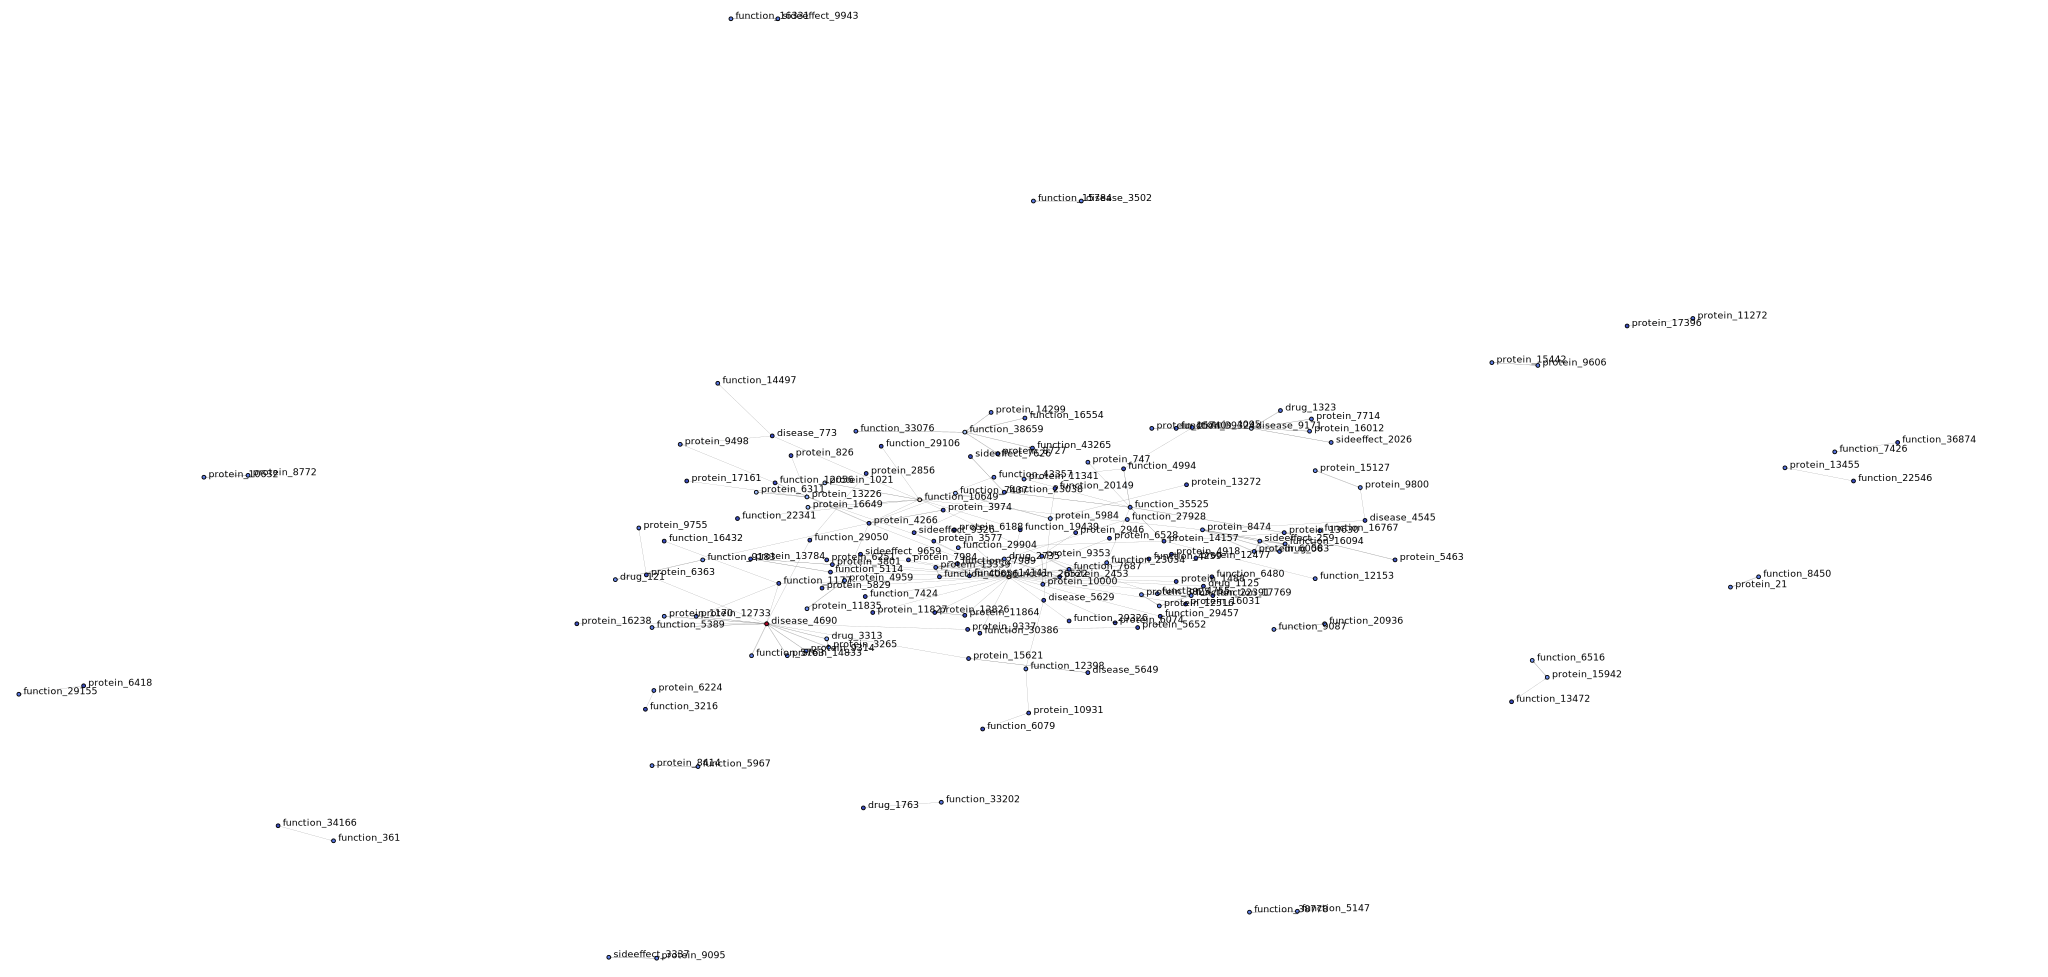

In [24]:
draw_graph(nx.k_core(biokg_sample, 1), show_names=True, node_size=2, edge_width=0.2)

In [25]:
degrees = dict(nx.degree(biokg_sample))
degrees

{'disease_5673': 0,
 'sideeffect_6120': 0,
 'protein_2856': 2,
 'drug_1763': 2,
 'function_44767': 0,
 'drug_2197': 0,
 'function_586': 0,
 'disease_5933': 0,
 'function_23038': 22,
 'sideeffect_7626': 1,
 'protein_16744': 0,
 'function_38068': 0,
 'function_32584': 0,
 'function_39215': 0,
 'drug_4685': 0,
 'protein_9597': 0,
 'function_15470': 0,
 'function_43832': 0,
 'function_4994': 2,
 'protein_5463': 6,
 'drug_8137': 0,
 'protein_5688': 0,
 'function_22058': 0,
 'function_7933': 0,
 'function_5169': 0,
 'function_35650': 0,
 'function_16218': 0,
 'function_18624': 0,
 'function_9468': 0,
 'disease_3502': 1,
 'function_2151': 0,
 'function_21729': 0,
 'function_11085': 0,
 'function_14325': 0,
 'sideeffect_6060': 0,
 'function_7524': 0,
 'function_14963': 0,
 'drug_872': 0,
 'protein_13455': 3,
 'function_456': 0,
 'drug_3175': 0,
 'function_20366': 0,
 'disease_3662': 0,
 'function_2122': 0,
 'drug_632': 0,
 'sideeffect_1437': 0,
 'drug_1378': 0,
 'function_11505': 0,
 'protein_